## Cell Type Exploration and Sim Demo

### Imports

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from env.imports import *

In [14]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [15]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()
GPUtil.getGPUs()
# if a number is seen a GPU is available

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

CPU Usage: 0.0%
RAM Usage: 6.1%
Available RAM: 353.7G
Total RAM: 376.8G
52.4G
None
Available GPUs: 0
XGBoost version: 2.0.3
cupy version: 13.1.0


RuntimeError: Could not find an available GPU after 1 attempts with 900 seconds interval.

### Cell type data processing
- Original model:  CIBERSORTx is a method for inferring cell-type-specific gene expression profiles (https://www.nature.com/articles/s41587-019-0114-2#MOESM1)
- Application 1 (Anderson, 2020): Transcriptional and imaging-genetic association of cortical interneurons, brain function, and schizophrenia risk (https://www.nature.com/articles/s41467-020-16710-x)
    - See Supplementary Data for per tissue sample inferred cell-types using Lake DFC/Vis datasets
- **Application 2** (Zhang, 2024): The cell-type underpinnings of human functional cortical connectome (https://www.nature.com/articles/s41593-024-01812-2)
    - See repo, https://github.com/XihanZhang/human-cellular-func-con, for inferred cell types from Jorstad (full brain), Lake (DFC/Vis) in Schaefer 400 Parcellation 
    - _Note:_ Missing regions need to be imputed to get full 400 ROI cortical coverage

The below cells outline (1) how we integrate the cell type information into our codebase, (2) exploratory data analysis, and (3) demos to run models with the cell type info.

#### Harmonize Inferred Cell Types from Zhang, 2024 with our Data

In [19]:
# Load in inferred cell types for Schaefer 400 parcellation
ref_dataset = "Jorstad" # "Lake_DFC" or "Lake_Vis"

ref_cell_type_df = pd.read_csv(f"./data/enigma/schaefer_{ref_dataset}_400_7Net_expr_mat_new_NormZscore0.3.csv")
last_col = ref_cell_type_df.iloc[:,-1]
ref_cell_type_df = pd.concat([last_col, ref_cell_type_df.iloc[:,:-1]], axis=1)
ref_cell_type_df = ref_cell_type_df.T

cell_type_df = ref_cell_type_df.rename(columns=ref_cell_type_df.iloc[0]).iloc[1:]
cell_type_df.index.name = 'label_7network'
cell_type_df


,Lamp5,Pax6,Vip,Sncg,Lamp5 Lhx6,L5 ET,L5/6 NP,L6 CT,L6b,Astro,...,OPC,L2/3 IT,L6 IT Car3,L4 IT,L6 IT,L5 IT,Chandelier,Pvalb,Sst,Sst Chodl
label_7network,,,,,,,,,,,,,,,,,,,,,
7Networks_LH_Vis_1,0.01788,0.005211,0.024241,0.036149,0.046252,0.000679,0.044468,0.021496,0.040369,0.029252,...,0.02051,0.21228,0.017791,0.041477,0.104096,0.21425,0.015076,0.006961,0.051609,0.007797
7Networks_LH_Vis_2,0.01572,0.013763,0.055608,0.063072,0.036132,0.0,0.052736,0.052417,0.037233,0.047726,...,0.031468,0.22365,0.023242,0.020326,0.066153,0.135331,0.028137,0.004559,0.035191,0.007828
7Networks_LH_Vis_3,0.018065,0.044421,0.0,0.0,0.01001,0.0,0.064571,0.008858,0.043829,0.0,...,0.266453,0.095256,0.0,0.092762,0.062249,0.192477,0.035935,0.01575,0.023626,0.005402
7Networks_LH_Vis_4,0.018772,0.02026,0.0,0.018067,0.029698,0.011508,0.041388,0.01194,0.030702,0.024141,...,0.081992,0.290656,0.001774,0.194989,0.080812,0.096792,0.0,0.01766,0.001144,0.000565
7Networks_LH_Vis_5,0.042415,0.023323,0.050445,0.005776,0.020364,0.059082,0.020042,0.000072,0.005941,0.009594,...,0.111644,0.201879,0.001061,0.205077,0.140896,0.000579,0.018897,0.042498,0.001778,0.000379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7Networks_RH_Default_PCC_5,0.046062,0.011399,0.013466,0.0,0.006902,0.047212,0.154551,0.0,0.0,0.039527,...,0.0,0.026111,0.0,0.329784,0.0,0.214604,0.0,0.018868,0.005903,0.0
7Networks_RH_Default_PCC_6,0.036317,0.060663,0.192963,0.037855,0.040127,0.124091,0.030866,0.0,0.0402,0.058363,...,0.079982,0.0,0.008951,0.050282,0.036497,0.151381,0.0,0.023532,0.0,0.003102
7Networks_RH_Default_PCC_7,0.086589,0.0,0.11466,0.000114,0.0,0.0,0.0,0.033153,0.048346,0.0,...,0.0,0.406992,0.0,0.072663,0.0,0.0,0.00116,0.15421,0.02494,0.0


Merge cell_type_df with S400_parcels, matching cell_type_df index with label_7network

In [20]:
# Load in S456 Atlas metadata
S400_parcels = pd.read_csv('./data/UKBB/atlas-4S456Parcels_dseg_reformatted.csv', index_col=0)[:400]
S400_parcels.head()

,network_label,label_7network,index_17network,label_17network,network_label_17network,atlas_name,id,hemisphere,structure,lobe,mni_x,mni_y,mni_z
label,,,,,,,,,,,,,
LH_Vis_1,Vis,7Networks_LH_Vis_1,61.0,17Networks_LH_DorsAttnA_TempOcc_2,DorsAttnA,4S456,1,L,cortex,Temporal,-32.18,-41.40,-21.06
LH_Vis_2,Vis,7Networks_LH_Vis_2,193.0,17Networks_LH_DefaultC_PHC_2,DefaultC,4S456,2,L,cortex,Temporal,-30.06,-32.55,-18.05
LH_Vis_3,Vis,7Networks_LH_Vis_3,1.0,17Networks_LH_VisCent_ExStr_1,VisCent,4S456,3,L,cortex,Temporal,-35.37,-62.03,-17.06
LH_Vis_4,Vis,7Networks_LH_Vis_4,13.0,17Networks_LH_VisPeri_ExStrInf_1,VisPeri,4S456,4,L,cortex,Temporal,-24.52,-54.45,-8.25
LH_Vis_5,Vis,7Networks_LH_Vis_5,2.0,17Networks_LH_VisCent_ExStr_2,VisCent,4S456,5,L,cortex,Occipital,-23.35,-72.70,-10.30


In [21]:
S400_cell_type_df = pd.merge(S400_parcels, cell_type_df,
                    left_on='label_7network',
                    right_index=True,
                    how='left')

S400_cell_type_df = S400_cell_type_df.set_index('label_7network')

cell_type_cols = S400_cell_type_df.columns[12:]

# Count rows where all cell type columns are NaN
nan_count = S400_cell_type_df[cell_type_cols].isna().all(axis=1).sum()
print(f"Number of rows with all NaN cell type values: {nan_count}")


S400_cell_type_df

Number of rows with all NaN cell type values: 114


,network_label,index_17network,label_17network,network_label_17network,atlas_name,id,hemisphere,structure,lobe,mni_x,...,OPC,L2/3 IT,L6 IT Car3,L4 IT,L6 IT,L5 IT,Chandelier,Pvalb,Sst,Sst Chodl
label_7network,,,,,,,,,,,,,,,,,,,,,
7Networks_LH_Vis_1,Vis,61.0,17Networks_LH_DorsAttnA_TempOcc_2,DorsAttnA,4S456,1,L,cortex,Temporal,-32.18,...,0.02051,0.21228,0.017791,0.041477,0.104096,0.21425,0.015076,0.006961,0.051609,0.007797
7Networks_LH_Vis_2,Vis,193.0,17Networks_LH_DefaultC_PHC_2,DefaultC,4S456,2,L,cortex,Temporal,-30.06,...,0.031468,0.22365,0.023242,0.020326,0.066153,0.135331,0.028137,0.004559,0.035191,0.007828
7Networks_LH_Vis_3,Vis,1.0,17Networks_LH_VisCent_ExStr_1,VisCent,4S456,3,L,cortex,Temporal,-35.37,...,0.266453,0.095256,0.0,0.092762,0.062249,0.192477,0.035935,0.01575,0.023626,0.005402
7Networks_LH_Vis_4,Vis,13.0,17Networks_LH_VisPeri_ExStrInf_1,VisPeri,4S456,4,L,cortex,Temporal,-24.52,...,0.081992,0.290656,0.001774,0.194989,0.080812,0.096792,0.0,0.01766,0.001144,0.000565
7Networks_LH_Vis_5,Vis,2.0,17Networks_LH_VisCent_ExStr_2,VisCent,4S456,5,L,cortex,Occipital,-23.35,...,0.111644,0.201879,0.001061,0.205077,0.140896,0.000579,0.018897,0.042498,0.001778,0.000379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7Networks_RH_Default_pCunPCC_5,Default,364.0,17Networks_RH_DefaultA_pCunPCC_2,DefaultA,4S456,396,R,cortex,Occipital,4.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7Networks_RH_Default_pCunPCC_6,Default,365.0,17Networks_RH_DefaultA_pCunPCC_3,DefaultA,4S456,397,R,cortex,Parietal,6.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7Networks_RH_Default_pCunPCC_7,Default,366.0,17Networks_RH_DefaultA_pCunPCC_4,DefaultA,4S456,398,R,cortex,Parietal,4.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_abagen_ inspired approach with homolog matching and inverse distance weighted average smoothing

In [26]:
def get_cell_type_cols(df):
    """Get cell type columns (all columns after first 12)"""
    return df.columns[12:]

def find_missing_regions(df, cell_type_cols):
    """Find regions with missing cell type data"""
    nan_mask = df[cell_type_cols].isna().all(axis=1)
    nan_rows = df[nan_mask]
    print(f"Found {len(nan_rows)} regions with missing cell type data")
    return nan_rows

def mirror_hemispheres(df, nan_rows, cell_type_cols):
    """Fill missing data by mirroring across hemispheres"""
    print("\nAttempting cross-hemispheric mirroring...")
    for idx, row in nan_rows.iterrows():
        print(f"\nProcessing region: {idx}")
        # Get label and determine hemisphere
        if row['hemisphere'] == 'L':
            homolog_label = idx.replace('LH_', 'RH_')
            print(f"Left hemisphere region, looking for right homolog: {homolog_label}")
        elif row['hemisphere'] == 'R':
            homolog_label = idx.replace('RH_', 'LH_')
            print(f"Right hemisphere region, looking for left homolog: {homolog_label}")
        else:
            print("Region has no hemisphere designation, skipping")
            continue
            
        try:
            # Find homolog row
            homolog = df.loc[homolog_label]
            if not homolog[cell_type_cols].isna().all():
                # Copy cell type values from homolog
                df.loc[idx, cell_type_cols] = homolog[cell_type_cols]
                print(f"Successfully mirrored data from {homolog_label}")
            else:
                print(f"Homolog {homolog_label} also has missing data")
        except KeyError:
            print(f"Could not find homologous region {homolog_label}")
    
    return df

def get_k_nearest(coords, all_coords, k=3, same_hemisphere=True):
    """Get k nearest neighbors based on Euclidean distance"""
    if same_hemisphere:
        # Filter coordinates by hemisphere
        hemisphere_mask = (all_coords[:,0] < 0) if coords[0] < 0 else (all_coords[:,0] > 0)
        all_coords = all_coords[hemisphere_mask]
    
    distances = np.sqrt(np.sum((all_coords - coords)**2, axis=1))
    return np.argsort(distances)[1:k+1], distances[np.argsort(distances)[1:k+1]]

def interpolate_missing(df, cell_type_cols):
    """Interpolate remaining missing values using distance-weighted averaging"""
    print("\nPerforming distance-weighted interpolation for remaining missing regions...")
    
    # Get updated list of regions still missing data
    remaining_nans = df[df[cell_type_cols].isna().all(axis=1)]
    print(f"\n{len(remaining_nans)} regions still have missing data after mirroring")

    # Get MNI coordinates for all regions
    coords = df[['mni_x', 'mni_y', 'mni_z']].values

    # Process each remaining region with missing data
    for idx, row in remaining_nans.iterrows():
        print(f"\nInterpolating region: {idx}")
        target_coords = coords[df.index.get_loc(idx)]
        
        # Get k nearest neighbors in same hemisphere
        neighbor_indices, distances = get_k_nearest(target_coords, coords, k=3)
        
        # Calculate inverse distance weights
        weights = 1 / distances
        weights = weights / np.sum(weights)
        
        # Get neighbor indices and their values
        neighbor_regions = df.index[neighbor_indices]
        print(f"Using neighbors: {neighbor_regions.tolist()}")
        print(f"With weights: {weights.round(3)}")
        
        # Weighted average of neighbor values
        weighted_values = np.average(
            df.iloc[neighbor_indices][cell_type_cols].values, 
            weights=weights,
            axis=0
        )
        
        # Update values
        df.loc[idx, cell_type_cols] = weighted_values
        print(f"Successfully interpolated values for {idx}")
    
    return df

def impute_cell_type_data(df):
    """Main function to impute missing cell type data"""
    cell_type_cols = get_cell_type_cols(df)
    nan_rows = find_missing_regions(df, cell_type_cols)
    
    # Step 1: Cross-hemispheric mirroring
    df = mirror_hemispheres(df, nan_rows, cell_type_cols)
    
    # Step 2: Distance-weighted interpolation
    df = interpolate_missing(df, cell_type_cols)
    
    # Print final summary
    final_nans = df[cell_type_cols].isna().all(axis=1).sum()
    print(f"\nFinal summary:")
    print(f"Original missing regions: {len(nan_rows)}")
    print(f"Remaining missing regions: {final_nans}")
    
    return df

# Run imputation
S400_cell_type_imputed_df = impute_cell_type_data(S400_cell_type_df)

Found 49 regions with missing cell type data

Attempting cross-hemispheric mirroring...

Processing region: 7Networks_LH_SalVentAttn_FrOperIns_1
Left hemisphere region, looking for right homolog: 7Networks_RH_SalVentAttn_FrOperIns_1
Homolog 7Networks_RH_SalVentAttn_FrOperIns_1 also has missing data

Processing region: 7Networks_LH_SalVentAttn_FrOperIns_2
Left hemisphere region, looking for right homolog: 7Networks_RH_SalVentAttn_FrOperIns_2
Homolog 7Networks_RH_SalVentAttn_FrOperIns_2 also has missing data

Processing region: 7Networks_LH_SalVentAttn_FrOperIns_3
Left hemisphere region, looking for right homolog: 7Networks_RH_SalVentAttn_FrOperIns_3
Homolog 7Networks_RH_SalVentAttn_FrOperIns_3 also has missing data

Processing region: 7Networks_LH_SalVentAttn_FrOperIns_5
Left hemisphere region, looking for right homolog: 7Networks_RH_SalVentAttn_FrOperIns_5
Homolog 7Networks_RH_SalVentAttn_FrOperIns_5 also has missing data

Processing region: 7Networks_LH_SalVentAttn_FrOperIns_6
Left he

Alternate approach using PLS for learning the relationship between raw expression and cell-type (_distilled model approach_)

In [45]:
from data.data_load import load_transcriptome

# GENE EXPRESSION DATA
S400_transcriptome = load_transcriptome(parcellation='S456', omit_subcortical=True)
S400_transcriptome.shape

# CELL TYPE DATA
cell_type_cols = get_cell_type_cols(S400_cell_type_df)
S400_cell_types = S400_cell_type_df[cell_type_cols].to_numpy(dtype=float)

# Find cell type indices
missing_data_mask = np.isnan(S400_cell_types).any(axis=1)
missing_data_indices = np.where(missing_data_mask)[0]


X shape: (286, 7380)
y shape: (286, 24)
Maximum possible components: 24


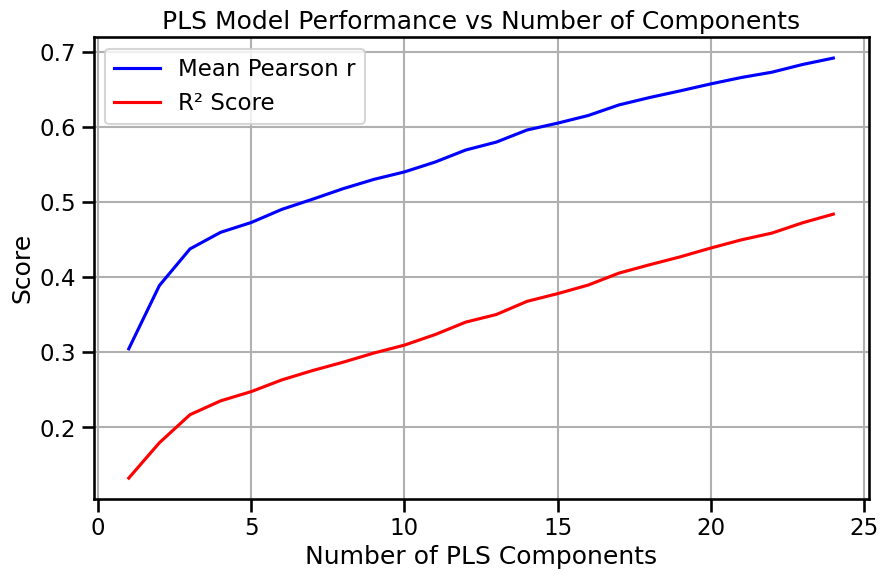

In [56]:
def evaluate_pls_components(X, y, n_components_range=range(1,21)):
    """
    Evaluate PLS performance across different numbers of components
    
    Parameters
    ----------
    X : array-like
        Gene expression data matrix
    y : array-like 
        Cell type proportion matrix
    n_components_range : range
        Range of components to test
        
    Returns
    -------
    pearson_rs : list
        Pearson correlations for each n_components
    r2_scores : list
        R^2 scores for each n_components
    """
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.metrics import r2_score
    from scipy.stats import pearsonr
    import numpy as np
    
    # Validate n_components doesn't exceed min dimension
    max_components = min(X.shape[0], X.shape[1], y.shape[1])
    n_components_range = [n for n in n_components_range if n <= max_components]
    
    pearson_rs = []
    r2_scores = []
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Maximum possible components: {max_components}")
    
    for n in n_components_range:
        # Fit PLS
        pls = PLSRegression(n_components=n, scale=True, max_iter=1000)
        pls.fit(X, y)
        
        # Get predictions
        y_pred = pls.predict(X)
        
        # Calculate metrics
        r2 = r2_score(y, y_pred)
        r2_scores.append(r2)
        
        # Calculate average pearson r across all cell types
        correlations = []
        for i in range(y.shape[1]):
            r = pearsonr(y[:,i], y_pred[:,i])[0]
            correlations.append(r)
        pearson_rs.append(np.mean(correlations))
        
    return pearson_rs, r2_scores

# Remove missing data indices
valid_indices = ~missing_data_mask
X_valid = S400_transcriptome[valid_indices]
y_valid = S400_cell_types[valid_indices]

# Evaluate PLS components - limit to number of cell types (24)
n_components_range = range(1,25)  # Limited to 24 components
pearson_rs, r2_scores = evaluate_pls_components(X_valid, y_valid, n_components_range)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(list(n_components_range), pearson_rs, 'b-', label='Mean Pearson r')
plt.plot(list(n_components_range), r2_scores, 'r-', label='R² Score')
plt.xlabel('Number of PLS Components')
plt.ylabel('Score')
plt.title('PLS Model Performance vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()


Sample 0 (r=0.976):
True values: [0.03181909 0.         0.02954607 0.00320936 0.01724708 0.03541291
 0.01727664 0.04199763 0.02424118 0.02325609 0.00482432 0.0146741
 0.00320588 0.00081014 0.01817854 0.11156292 0.00790879 0.43845236
 0.08102396 0.02067909 0.01981011 0.04188717 0.01297657 0.        ]
Predicted: [5.31078662e-02 0.00000000e+00 6.00357415e-02 1.85025534e-03
 1.27544598e-02 4.68268178e-03 1.30036396e-02 4.39222505e-02
 2.01675393e-02 8.93504147e-03 6.98000061e-03 1.69089781e-02
 1.06788384e-02 3.32289417e-04 7.16907429e-03 5.51913770e-02
 1.53359813e-02 5.95616727e-01 4.15859805e-02 0.00000000e+00
 2.11029082e-03 7.13223086e-02 1.62742107e-02 0.00000000e+00]

Sample 0 (r=0.664):
True values: [0.01784003 0.         0.20798506 0.         0.0333249  0.26546902
 0.         0.11896648 0.03611724 0.         0.01142935 0.00653557
 0.01291247 0.         0.01562617 0.         0.01885911 0.0221498
 0.         0.16555848 0.         0.00161174 0.02471828 0.04089629]
Predicted: [0.02471

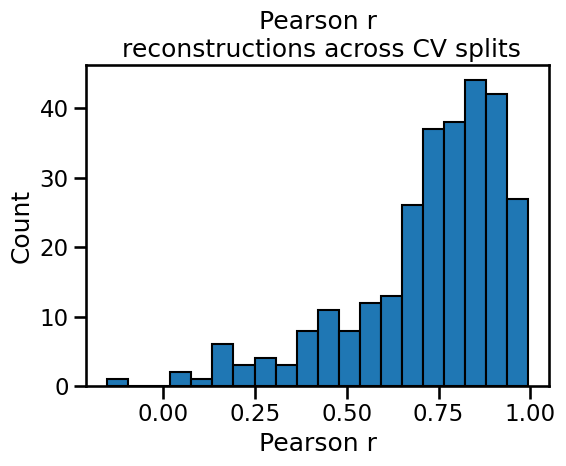

Mean Pearson r: 0.726 ± 0.207


In [74]:
def run_kfold_pls_cv(X, y, n_splits=10, n_components=20, random_state=42):
    """
    Run k-fold cross validation for PLS regression and evaluate performance.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input data
    y : array-like of shape (n_samples, n_targets)
        Target data
    n_splits : int, default=10
        Number of folds for cross validation
    n_components : int, default=20
        Number of components for PLS regression
    random_state : int, default=42
        Random state for reproducibility
        
    Returns
    -------
    fold_pearson_rs : list
        Pearson r scores for each test sample
    """
    # Initialize arrays to store results
    fold_pearson_rs = []

    # Create KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Perform k-fold cross validation
    for train_idx, test_idx in kf.split(X):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Fit PLS model
        pls = PLSRegression(n_components=n_components, scale=True, max_iter=1000)
        pls.fit(X_train, y_train)
        
        # Get predictions on test set and clip negative values
        y_pred = pls.predict(X_test)
        y_pred = np.clip(y_pred, 0, None)  # Clip negative values to 0
        
        # Calculate pearson r for each sample in test set
        for i in range(len(test_idx)):
            r = pearsonr(y_test[i], y_pred[i])[0]
            print(f"Sample {i} (r={r:.3f}):") 
            print("True values:", y_test[i])
            print("Predicted:", y_pred[i])
            print()
            fold_pearson_rs.append(r)
            
    return fold_pearson_rs

def plot_cv_results(pearson_rs):
    """
    Plot histogram of cross-validation results.
    
    Parameters
    ----------
    pearson_rs : list
        List of Pearson r scores
    """
    plt.figure(figsize=(6,5))

    plt.hist(pearson_rs, bins=20, edgecolor='black')
    plt.xlabel('Pearson r')
    plt.ylabel('Count')
    plt.title('Pearson r\n reconstructions across CV splits')

    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Mean Pearson r: {np.mean(pearson_rs):.3f} ± {np.std(pearson_rs):.3f}")

# Run cross-validation
fold_pearson_rs = run_kfold_pls_cv(X_valid, y_valid, n_splits=286, n_components=10, random_state=42)

# Plot results
plot_cv_results(fold_pearson_rs)


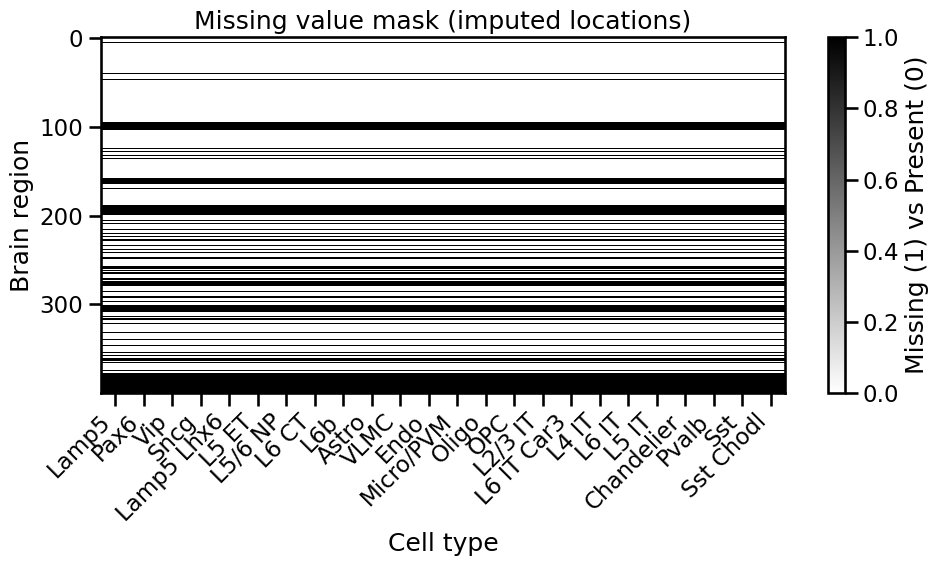

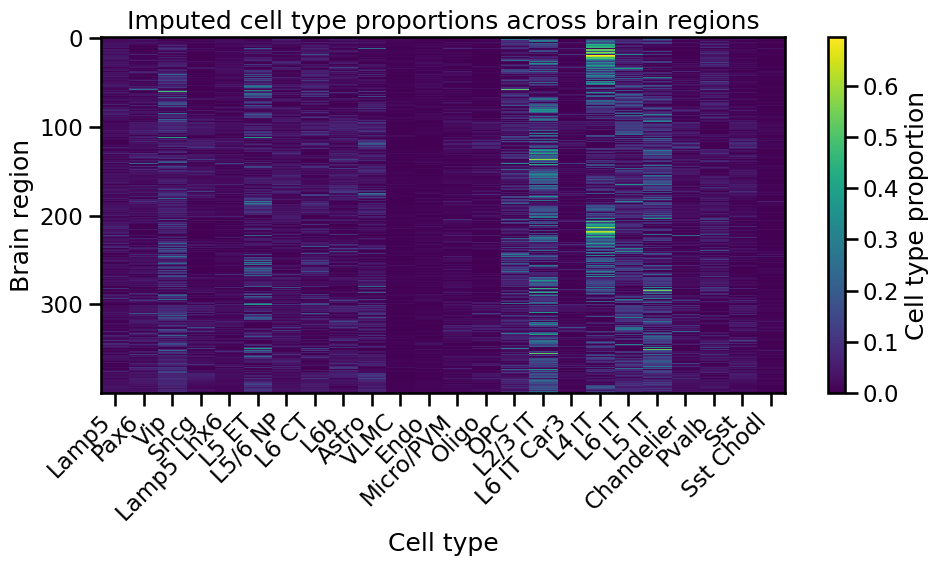

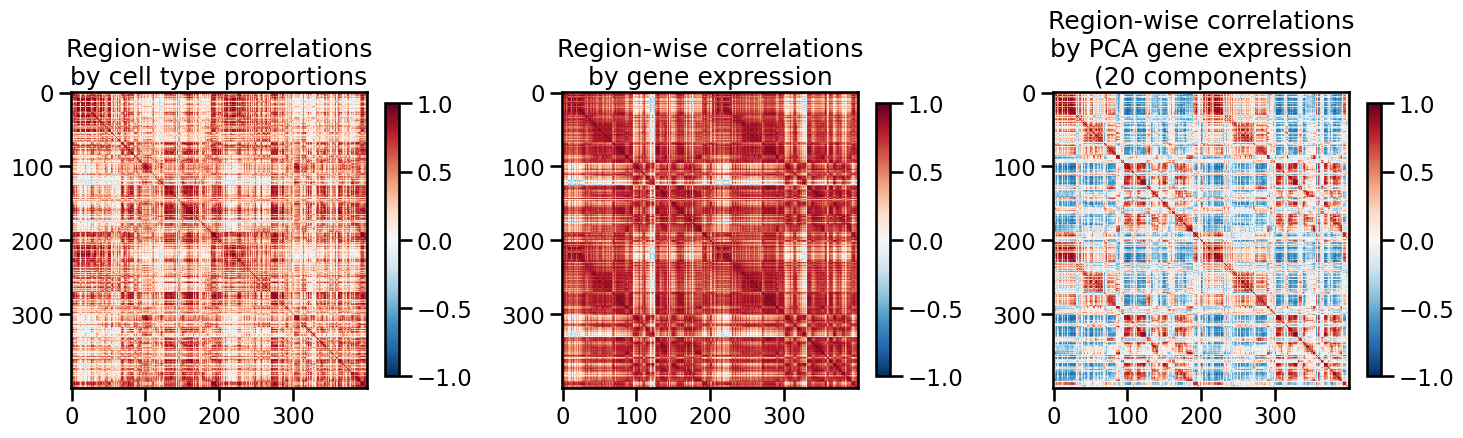

In [83]:
def impute_cell_types(transcriptome, cell_types, n_components=10):
    """
    Impute missing cell type data using PLS regression on transcriptome data.
    
    Parameters
    ----------
    transcriptome : ndarray
        Gene expression data matrix (n_samples x n_genes)
    cell_types : ndarray 
        Cell type proportion matrix with missing values (n_samples x n_cell_types)
    n_components : int, optional
        Number of PLS components to use. Default is 10.
        
    Returns
    -------
    ndarray
        Imputed cell type matrix with no missing values
    """
    # Create copy of cell types to fill
    cell_types_imputed = cell_types.copy()
    
    # Get indices of samples with missing data
    missing_idx = np.isnan(cell_types).any(axis=1)
    
    # Split into training (non-missing) and test (missing) sets
    X_train = transcriptome[~missing_idx]
    y_train = cell_types[~missing_idx]
    X_test = transcriptome[missing_idx]
    
    # Fit PLS model
    pls = PLSRegression(n_components=n_components, scale=True, max_iter=1000)
    pls.fit(X_train, y_train)
    
    # Predict missing values
    y_pred = pls.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)  # Clip negative values
    
    # Fill in missing values
    cell_types_imputed[missing_idx] = y_pred
    
    return cell_types_imputed

# Impute missing values
imputed_cell_types = impute_cell_types(S400_transcriptome, S400_cell_types, n_components=10)

# Create mask of imputed values
missing_mask = np.isnan(S400_cell_types).astype(int)
# Plot missing value mask
plt.figure(figsize=(10,6))
plt.imshow(missing_mask, aspect='auto', cmap='binary', interpolation='none')
plt.colorbar(label='Missing (1) vs Present (0)')
plt.xlabel('Cell type')
plt.ylabel('Brain region') 
plt.title('Missing value mask (imputed locations)')
plt.xticks(range(len(cell_type_cols)), cell_type_cols, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot imputed matrix
plt.figure(figsize=(10, 6))
plt.imshow(imputed_cell_types, aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar(label='Cell type proportion')
plt.xlabel('Cell type')
plt.ylabel('Brain region')
plt.title('Imputed cell type proportions across brain regions')
plt.xticks(range(len(cell_type_cols)), cell_type_cols, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Compute correlation matrices
cell_type_corr = np.corrcoef(imputed_cell_types)
gene_expr_corr = np.corrcoef(S400_transcriptome)

# Compute PCA and get components explaining 90% variance
pca = PCA()
pca.fit(S400_transcriptome)
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum >= 0.9) + 1
pca_reduced = PCA(n_components=n_components_90)
gene_expr_pca = pca_reduced.fit_transform(S400_transcriptome)
gene_expr_pca_corr = np.corrcoef(gene_expr_pca)

# Plot correlation matrices side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

im1 = ax1.imshow(cell_type_corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Region-wise correlations\nby cell type proportions')
plt.colorbar(im1, ax=ax1, shrink=0.5)

im2 = ax2.imshow(gene_expr_corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Region-wise correlations\nby gene expression')
plt.colorbar(im2, ax=ax2, shrink=0.5)

im3 = ax3.imshow(gene_expr_pca_corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax3.set_title(f'Region-wise correlations\nby PCA gene expression\n({n_components_90} components)')
plt.colorbar(im3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

In [87]:
# Save imputed cell type proportions to CSV
# pd.DataFrame(imputed_cell_types, index=S400_cell_type_df.index, columns=cell_type_cols).to_csv('data/enigma/schaef400_cell_types.csv')

In [16]:
importlib.reload(data.data_load)


<module 'data.data_load' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_load.py'>

In [27]:
from data.data_load import load_transcriptome, load_cell_types, load_network_labels

region_labels, network_labels = load_network_labels(parcellation='S456', omit_subcortical=True)
cell_types, cell_type_labels = load_cell_types(parcellation='S456', omit_subcortical=True)


Cell types data shape: (400, 24)
Cell type columns: ['Lamp5', 'Pax6', 'Vip', 'Sncg', 'Lamp5 Lhx6', 'L5 ET', 'L5/6 NP', 'L6 CT', 'L6b', 'Astro', 'VLMC', 'Endo', 'Micro/PVM', 'Oligo', 'OPC', 'L2/3 IT', 'L6 IT Car3', 'L4 IT', 'L6 IT', 'L5 IT', 'Chandelier', 'Pvalb', 'Sst', 'Sst Chodl']
First few rows:
                       Lamp5      Pax6       Vip      Sncg  Lamp5 Lhx6  \
label_7network                                                           
7Networks_LH_Vis_1  0.017880  0.005211  0.024241  0.036149    0.046252   
7Networks_LH_Vis_2  0.015720  0.013763  0.055608  0.063072    0.036132   
7Networks_LH_Vis_3  0.018065  0.044421  0.000000  0.000000    0.010010   
7Networks_LH_Vis_4  0.018772  0.020260  0.000000  0.018067    0.029698   
7Networks_LH_Vis_5  0.042415  0.023323  0.050445  0.005776    0.020364   

                       L5 ET   L5/6 NP     L6 CT       L6b     Astro  ...  \
label_7network                                                        ...   
7Networks_LH_Vis_1  0.00067

In [28]:
cell_type_labels

['7Networks_LH_Vis_1',
 '7Networks_LH_Vis_2',
 '7Networks_LH_Vis_3',
 '7Networks_LH_Vis_4',
 '7Networks_LH_Vis_5',
 '7Networks_LH_Vis_6',
 '7Networks_LH_Vis_7',
 '7Networks_LH_Vis_8',
 '7Networks_LH_Vis_9',
 '7Networks_LH_Vis_10',
 '7Networks_LH_Vis_11',
 '7Networks_LH_Vis_12',
 '7Networks_LH_Vis_13',
 '7Networks_LH_Vis_14',
 '7Networks_LH_Vis_15',
 '7Networks_LH_Vis_16',
 '7Networks_LH_Vis_17',
 '7Networks_LH_Vis_18',
 '7Networks_LH_Vis_19',
 '7Networks_LH_Vis_20',
 '7Networks_LH_Vis_21',
 '7Networks_LH_Vis_22',
 '7Networks_LH_Vis_23',
 '7Networks_LH_Vis_24',
 '7Networks_LH_Vis_25',
 '7Networks_LH_Vis_26',
 '7Networks_LH_Vis_27',
 '7Networks_LH_Vis_28',
 '7Networks_LH_Vis_29',
 '7Networks_LH_Vis_30',
 '7Networks_LH_Vis_31',
 '7Networks_LH_SomMot_1',
 '7Networks_LH_SomMot_2',
 '7Networks_LH_SomMot_3',
 '7Networks_LH_SomMot_4',
 '7Networks_LH_SomMot_5',
 '7Networks_LH_SomMot_6',
 '7Networks_LH_SomMot_7',
 '7Networks_LH_SomMot_8',
 '7Networks_LH_SomMot_9',
 '7Networks_LH_SomMot_10',
 '7N

In [29]:
region_labels

['LH_H_Vis_1',
 'LH_H_Vis_2',
 'LH_H_Vis_3',
 'LH_H_Vis_4',
 'LH_H_Vis_5',
 'LH_H_Vis_6',
 'LH_H_Vis_7',
 'LH_H_Vis_8',
 'LH_H_Vis_9',
 'LH_H_Vis_10',
 'LH_H_Vis_11',
 'LH_H_Vis_12',
 'LH_H_Vis_13',
 'LH_H_Vis_14',
 'LH_H_Vis_15',
 'LH_H_Vis_16',
 'LH_H_Vis_17',
 'LH_H_Vis_18',
 'LH_H_Vis_19',
 'LH_H_Vis_20',
 'LH_H_Vis_21',
 'LH_H_Vis_22',
 'LH_H_Vis_23',
 'LH_H_Vis_24',
 'LH_H_Vis_25',
 'LH_H_Vis_26',
 'LH_H_Vis_27',
 'LH_H_Vis_28',
 'LH_H_Vis_29',
 'LH_H_Vis_30',
 'LH_H_Vis_31',
 'LH_H_SomMot_1',
 'LH_H_SomMot_2',
 'LH_H_SomMot_3',
 'LH_H_SomMot_4',
 'LH_H_SomMot_5',
 'LH_H_SomMot_6',
 'LH_H_SomMot_7',
 'LH_H_SomMot_8',
 'LH_H_SomMot_9',
 'LH_H_SomMot_10',
 'LH_H_SomMot_11',
 'LH_H_SomMot_12',
 'LH_H_SomMot_13',
 'LH_H_SomMot_14',
 'LH_H_SomMot_15',
 'LH_H_SomMot_16',
 'LH_H_SomMot_17',
 'LH_H_SomMot_18',
 'LH_H_SomMot_19',
 'LH_H_SomMot_20',
 'LH_H_SomMot_21',
 'LH_H_SomMot_22',
 'LH_H_SomMot_23',
 'LH_H_SomMot_24',
 'LH_H_SomMot_25',
 'LH_H_SomMot_26',
 'LH_H_SomMot_27',
 'LH_H_So

In [30]:
print(f"Number of region labels: {len(region_labels)}")
print(f"Number of cell type labels: {len(cell_type_labels)}")


Number of region labels: 400
Number of cell type labels: 400


In [31]:
# Compare region and cell type labels from second to last underscore to end
print("Starting comparison of region and cell type labels...")
discrepancies = 0
for i, (reg, cell) in enumerate(zip(region_labels, cell_type_labels)):
    reg_suffix = '_'.join(reg.split('_')[-2:])  # Get last two segments
    cell_suffix = '_'.join(cell.split('_')[-2:])  # Get last two segments
    print(f"Comparing pair {i+1}: {reg_suffix} vs {cell_suffix}")
    if reg_suffix != cell_suffix:
        discrepancies += 1
        print(f"Mismatch found: {reg} vs {cell}")

print(f"\nComparison complete.")
print(f"Total discrepancies found: {discrepancies}")

Starting comparison of region and cell type labels...
Comparing pair 1: Vis_1 vs Vis_1
Comparing pair 2: Vis_2 vs Vis_2
Comparing pair 3: Vis_3 vs Vis_3
Comparing pair 4: Vis_4 vs Vis_4
Comparing pair 5: Vis_5 vs Vis_5
Comparing pair 6: Vis_6 vs Vis_6
Comparing pair 7: Vis_7 vs Vis_7
Comparing pair 8: Vis_8 vs Vis_8
Comparing pair 9: Vis_9 vs Vis_9
Comparing pair 10: Vis_10 vs Vis_10
Comparing pair 11: Vis_11 vs Vis_11
Comparing pair 12: Vis_12 vs Vis_12
Comparing pair 13: Vis_13 vs Vis_13
Comparing pair 14: Vis_14 vs Vis_14
Comparing pair 15: Vis_15 vs Vis_15
Comparing pair 16: Vis_16 vs Vis_16
Comparing pair 17: Vis_17 vs Vis_17
Comparing pair 18: Vis_18 vs Vis_18
Comparing pair 19: Vis_19 vs Vis_19
Comparing pair 20: Vis_20 vs Vis_20
Comparing pair 21: Vis_21 vs Vis_21
Comparing pair 22: Vis_22 vs Vis_22
Comparing pair 23: Vis_23 vs Vis_23
Comparing pair 24: Vis_24 vs Vis_24
Comparing pair 25: Vis_25 vs Vis_25
Comparing pair 26: Vis_26 vs Vis_26
Comparing pair 27: Vis_27 vs Vis_27
C